In [3]:
import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.otherfunctions.multiplot import highlight_cell
from codes.experimentclasses.TolueneAngles import TolueneAngles
#from codes.otherfunctions.multirun import get_coeffs_reps
#from codes.otherfunctions.multirun import get_grads_reps_pca2
from codes.otherfunctions.multiplot import plot_betas, plot_betas2reorder
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_1d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute_1d
from codes.otherfunctions.multirun import get_cosines
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle
from codes.flasso.Replicate import Replicate


from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
import numpy as np
import scipy
import os
#workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]



from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle


def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M, dg_M, dg_w, dg_w_pca, dgw_norm)

#set parameters
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
nreps = 25
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 2 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 1 #manifold dimension
dimnoise = 1
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0, 0, 0, 0, 1, 6, 5, 6, 5, 4, 4, 3, 3, 2, 2])
jj = np.asarray([8, 9, 7, 1, 6, 14, 13, 5, 4, 12, 3, 11, 2, 10, 1])

#these are just for loading... probably not necessary
atoms4 = np.asarray([[9,0,1,2],[0,1,2,3],[1,2,3,4],[2,3,4,5],[3,4,5,6],[4,5,6,1],[5,6,1,0],[0,1,3,11],[10,2,4,12],[11,3,5,13],[12,4,6,14],[10,2,6,13],[0,1,5,13],[11,3,6,14],[12,4,1,0],[10,2,5,13]],dtype = int)
lambda_max = 1
max_search = 30
new_MN = True
savename = 'toluene_010521_pdiagram_rep5n500_oldnorm'
savefolder = 'toluene'
loadfolder = 'toluene'
loadname = 'toluene_010521_pdiagram_rep5n500_oldnorm'

folder = workingdirectory + '/Figures/toluene/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)
src = workingdirectory + '/codes/experiments/toluene_110120_nsel100_nreps25.py'
filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
if new_MN == True:
    experiment = TolueneAngles(dim, n,ii, jj, cores, atoms4)
    projector = np.load(data_wd + '/untracked_data/chemistry_data/tolueneangles020619_pca50_components.npy')
    #experiment.M = experiment.load_data()  # if noise == False then noise parameters are overriden
    
    n = experiment.n
    d = experiment.d
    dim = experiment.dim
    natoms = experiment.natoms
    atoms3 = experiment.atoms3

    filename_xyz = data_wd + '/untracked_data/chemistry_data/toluene.mat'
    filename_angle_indices = data_wd + '/untracked_data/chemistry_data/tolueneindices020619.npy'
    data_xyz_loaded = scipy.io.loadmat(filename_xyz)
    angle_indices = np.load(filename_angle_indices)
    positions = data_xyz_loaded['R'][angle_indices]
    experiment.positions = positions
    filename_angles = data_wd + '/untracked_data/chemistry_data/tolueneangles020619.npy'
    data = np.reshape(np.load(filename_angles), (50000, 3 * len(atoms3)))
    data = np.arccos(data)
    experiment.M  = RiemannianManifold(data, dim)
    
    experiment.Mpca = RiemannianManifold(
        np.load(data_wd + '/untracked_data/chemistry_data/tolueneangles020619_pca50.npy'), dim)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)


[[ 9  0  1  2]
 [ 0  1  2  3]
 [ 1  2  3  4]
 [ 2  3  4  5]
 [ 3  4  5  6]
 [ 4  5  6  1]
 [ 5  6  1  0]
 [ 0  1  3 11]
 [10  2  4 12]
 [11  3  5 13]
 [12  4  6 14]
 [10  2  6 13]
 [ 0  1  5 13]
 [11  3  6 14]
 [12  4  1  0]
 [10  2  5 13]]


In [4]:
#get_atoms_4

ii = np.asarray([0, 0, 0, 0, 1, 6, 5, 6, 5, 4, 4, 3, 3, 2, 2])
jj = np.asarray([8, 9, 7, 1, 6, 14, 13, 5, 4, 12, 3, 11, 2, 10, 1])

atoms4 , p = get_atoms_4(natoms,ii,jj)

In [5]:
g1 = experiment.get_g_full_sub(experiment.M.data, atoms4[0])

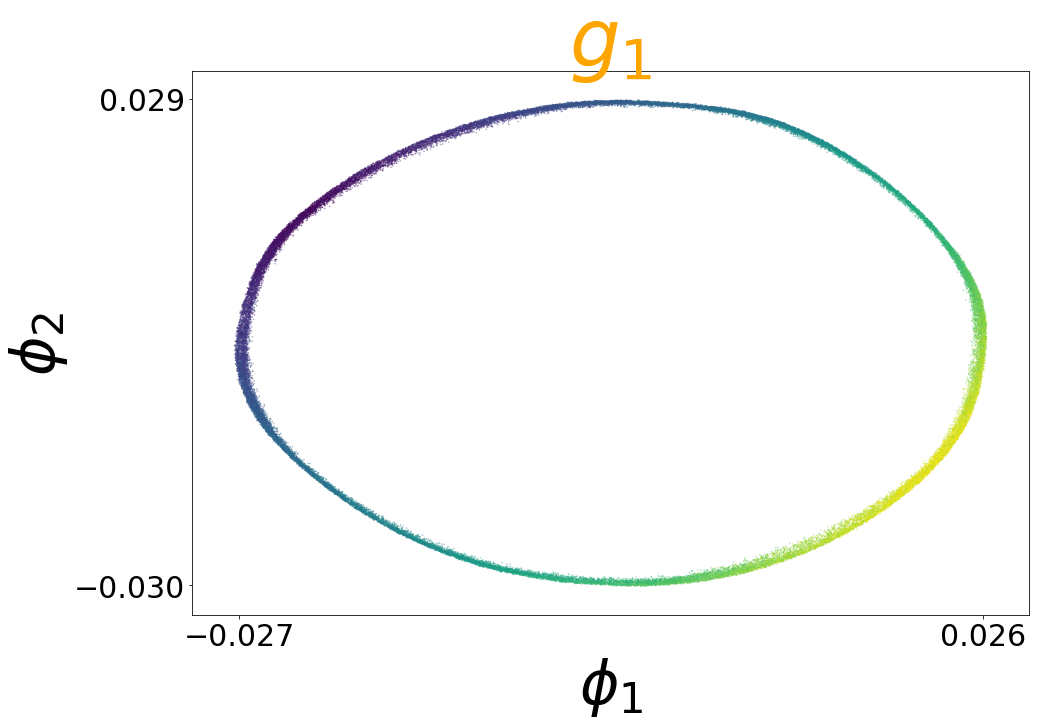

In [6]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
#z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1)

ax.scatter(x, y, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
#ax.set_zlabel(r'$\phi_3$', fontsize = 30)
ax.set_title(r'$g_{1}$', fontsize = 80, color= 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.tick_params(labelsize=30)

#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/tol_groundtruth_g1')

0
1
2
3
4
5


Text(0.5, 0.98, 'Pairplot of top 6 $\\xi$ coordinates in Toluene')

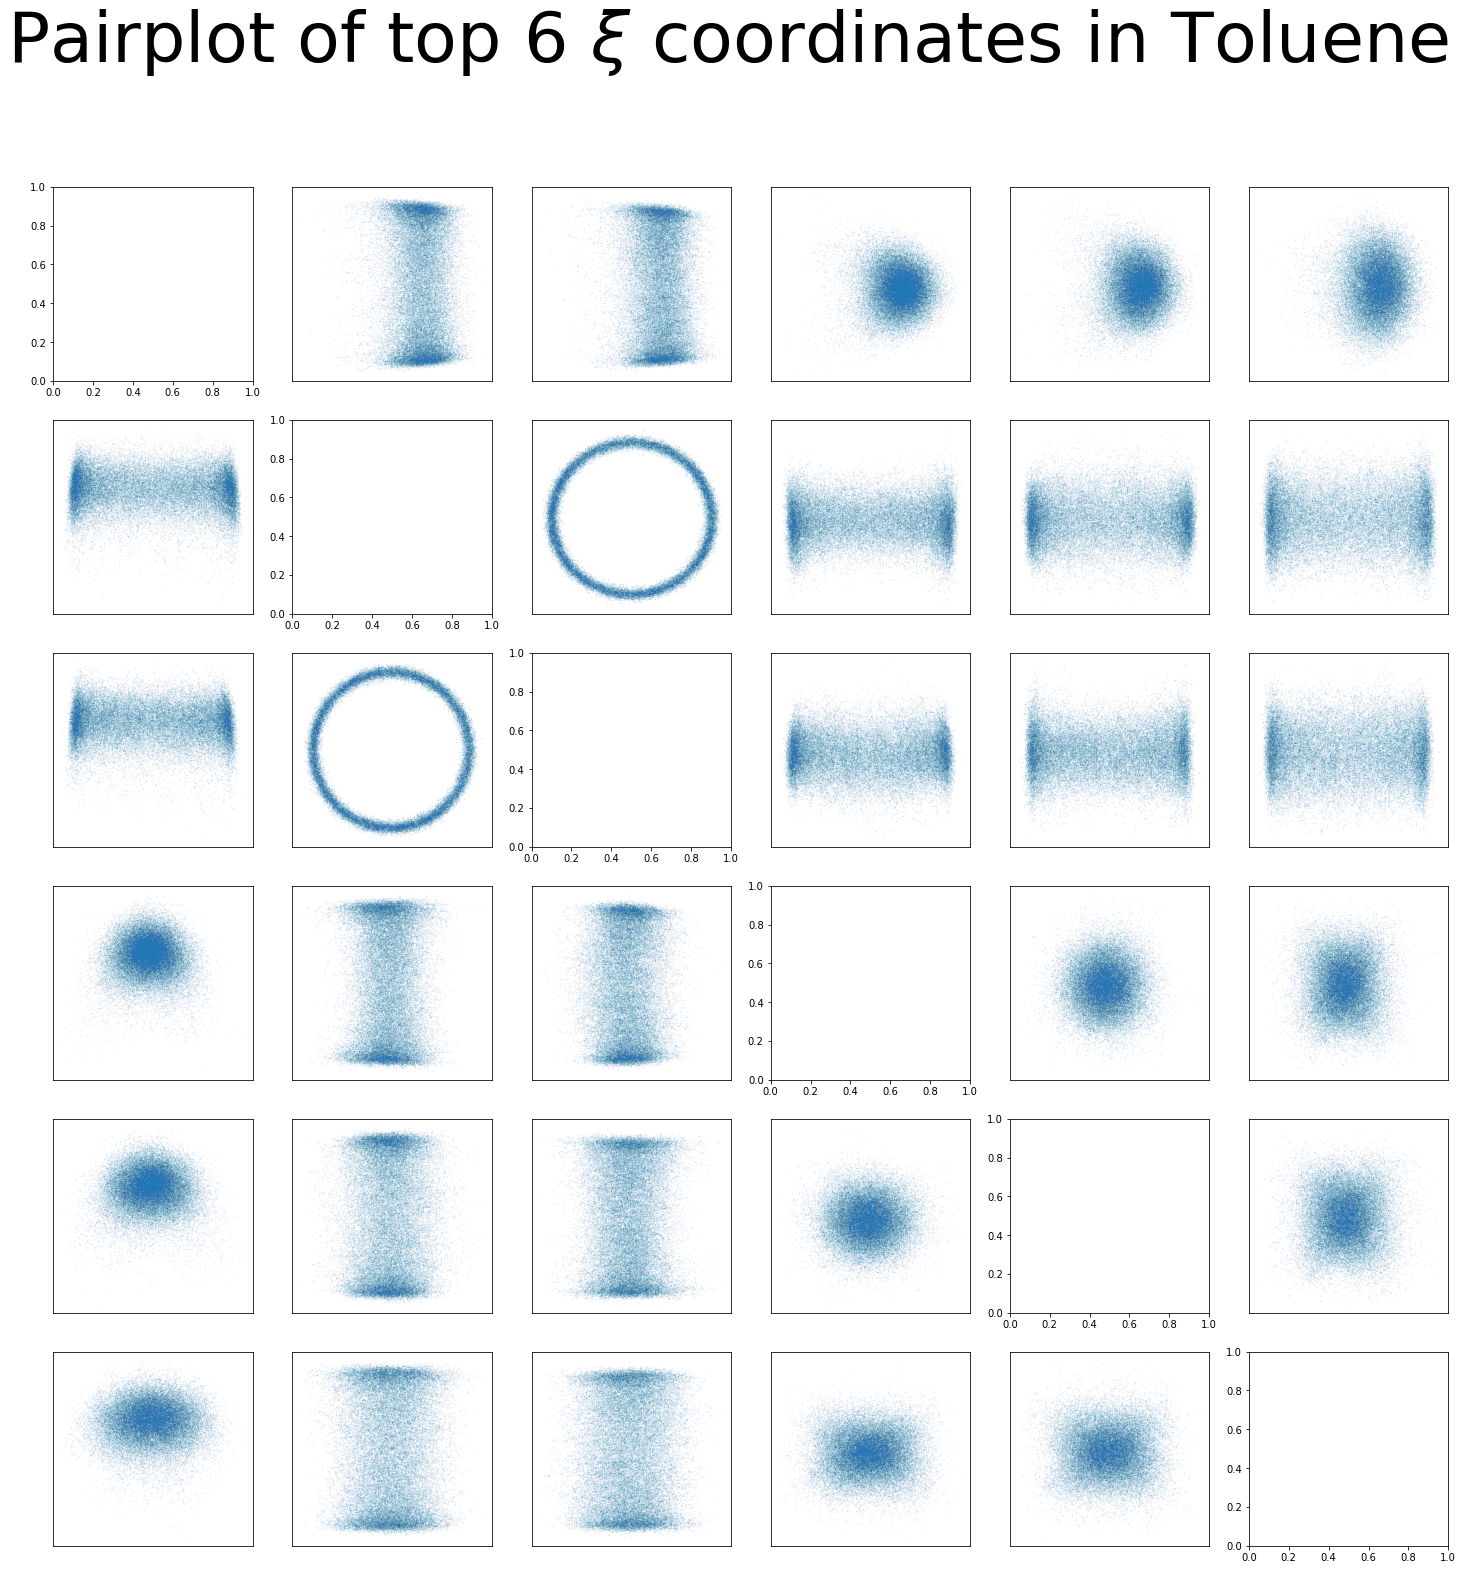

In [7]:
data = experiment.N.data

s = 100
alpha = .5
fig, axes = plt.subplots(6,6, figsize = (25,25))

for d in range(6):
    print(d)
    for e in range(6):
        if d != e:
            axes[d,e].scatter(experiment.Mpca.data[:,d],experiment.Mpca.data[:,e], s = .1, alpha = .1)
            axes[d,e].set_xticklabels([])
            axes[d,e].set_yticklabels([])
            axes[d,e].set_xticks([])
            axes[d,e].set_yticks([])
            
fig = plt.gcf()
fig.suptitle('Pairplot of top 6 ' + r'$\xi$' + ' coordinates in Toluene', fontsize=70)

#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/tol_xi_pairplot')
            #axes[d,e].set_axis_off()
#axes.set_   